https://twitter.com/ysmemoirs/status/1544957417678864384

In [1]:
using Distributions
using StatsPlots
default(fmt=:png, titlefontsize=10, tickfontsize=6)
using Memoization
using SymPy

function _likelihood(w, r; a=43, b=7, c=24, d=26, W=5000, R=1000)
    a+b ≤ w+r || return 0.0
    c+d ≤ W+R-(w+r) || return 0.0
    hgA = Hypergeometric(w, r, a+b)
    hgB = Hypergeometric(W-w, R-r, c+d)
    likA = pdf(hgA, a)
    likB = pdf(hgB, c)
    likA * likB
end

@memoize function calculate_likelihoods(; a=43, b=7, c=24, d=26, W=5000, R=1000)
    lik = Matrix{Float64}(undef, W+1, R+1)
    Ws, Rs = 0:W, 0:R 
    Threads.@threads for j in eachindex(Rs)
        for i in eachindex(Ws)
            lik[i, j] = _likelihood(Ws[i], Rs[j]; a, b, c, d, W, R)
        end
    end
    (; lik, Ws, Rs)
end

function plot_likelihoods(f = identity;
        a=43, b=7, c=24, d=26, W=5000, R=1000,
        ws=0:W, rs=0:R, color=:CMRmap, colorbar=true, clims=nothing,
        plot_line=false, plot_contourf=false, 
        title="", kwargs...)
    (; lik, Ws, Rs) = calculate_likelihoods(; a, b, c, d, W, R)
    xidx, yidx = 1 .+ ws, 1 .+ rs
    @views if isnothing(clims)
        likmin, likmax = extrema(f, lik[xidx, yidx])
        clims = (likmin - 0.05(likmax - likmin), likmax)
    end
    @views if plot_contourf
        contourf(Ws[xidx], Rs[yidx], f.(lik[xidx, yidx])'; color, colorbar, clims, kwargs...)
    else
        heatmap(Ws[xidx], Rs[yidx], f.(lik[xidx, yidx])'; color, colorbar, clims, kwargs...)
    end
    plot_line && plot!(x -> (d/c)*(x - W) + R; label="", c=:cyan)
    @views plot!(xlim=extrema(Ws[xidx]), ylim=extrema(Rs[yidx]))
    plot!(xguide="w", yguide="r")
    title!(title)
end

plot_likelihoods (generic function with 2 methods)

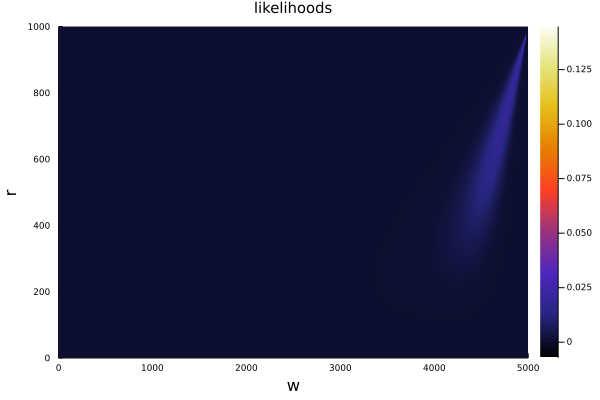

In [2]:
plot_likelihoods(; title="likelihoods")

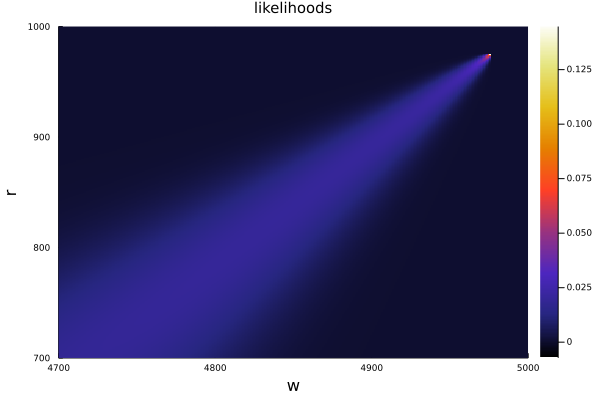

In [3]:
plot_likelihoods(ws=4700:5000, rs=700:1000, title="likelihoods")

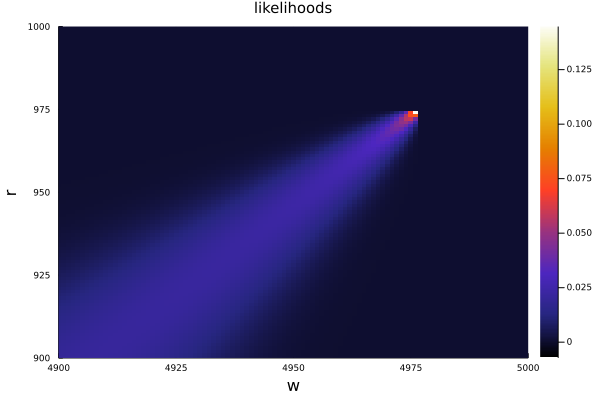

In [4]:
plot_likelihoods(ws=4900:5000, rs=900:1000, title="likelihoods")

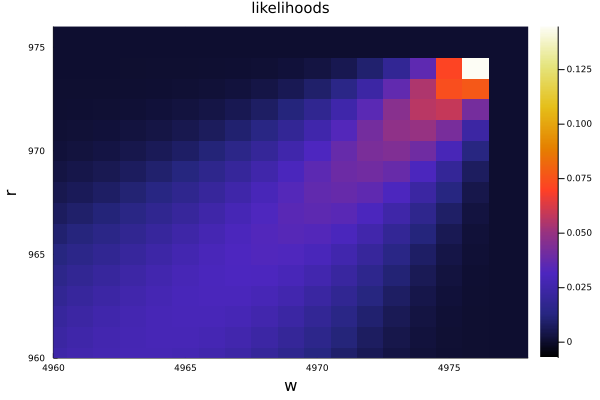

In [5]:
plot_likelihoods(ws=4960:4978, rs=960:976, title="likelihoods")

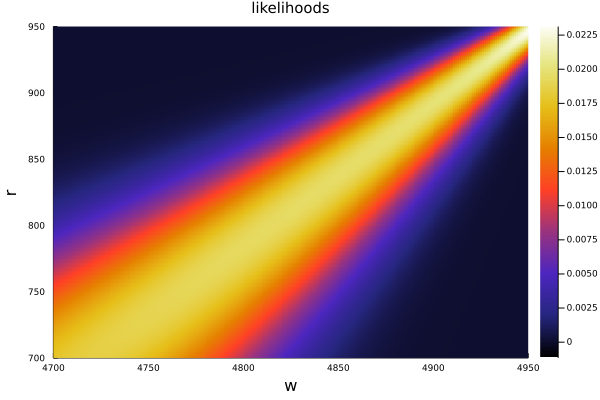

In [6]:
plot_likelihoods(ws=4700:4950, rs=700:950, title="likelihoods")

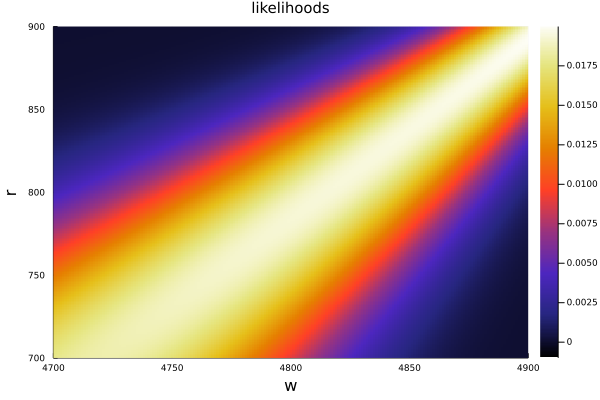

In [7]:
plot_likelihoods(ws=4700:4900, rs=700:900, title="likelihoods")

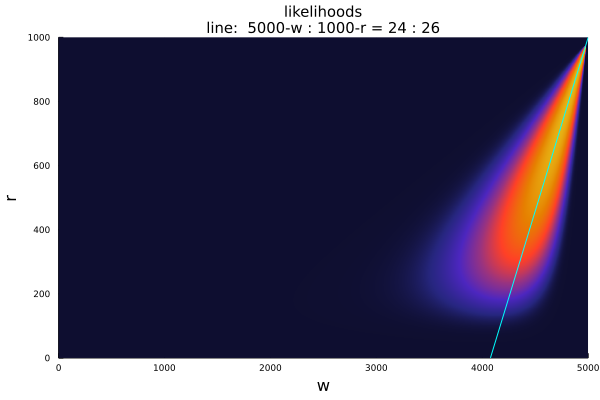

In [8]:
plot_likelihoods(p -> log(p + 1e-4); colorbar=false,
    plot_line=true, title="likelihoods\nline:  5000-w : 1000-r = 24 : 26")

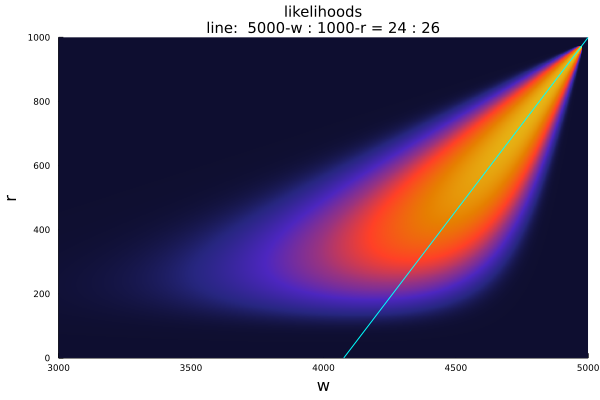

In [9]:
plot_likelihoods(p -> log(p + 1e-4); ws=3000:5000, colorbar=false,
    plot_line=true, title="likelihoods\nline:  5000-w : 1000-r = 24 : 26")

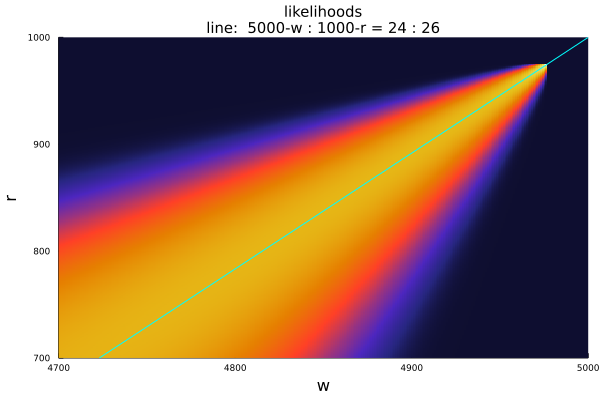

In [10]:
plot_likelihoods(p -> log(p + 1e-4); ws=4700:5000, rs=700:1000, colorbar=false,
    plot_line=true, title="likelihoods\nline:  5000-w : 1000-r = 24 : 26")

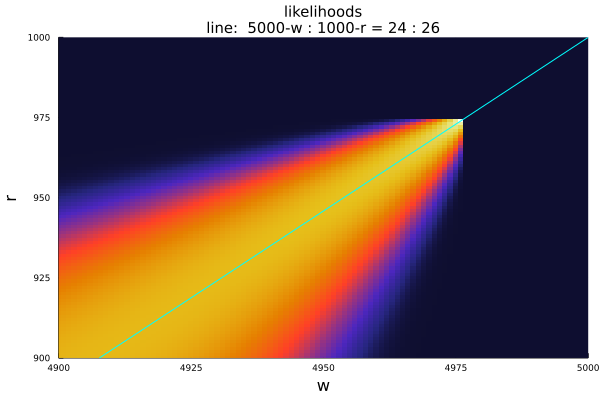

In [11]:
plot_likelihoods(p -> log(p + 1e-4); ws=4900:5000, rs=900:1000, colorbar=false,
    plot_line=true, title="likelihoods\nline:  5000-w : 1000-r = 24 : 26")

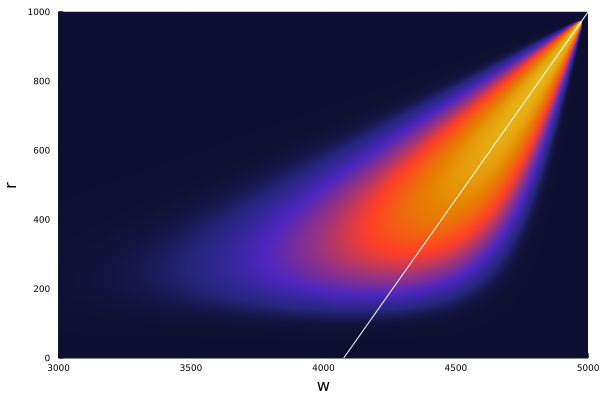

In [12]:
f(x) = (26/24)*(x - 5000) + 1000
plot_likelihoods(p -> log(p + 1e-4); ws=3000:5000, colorbar=false, label="likelihoods")
plot!(x -> f(x); label="", c=:white)

In [13]:
(; lik, Ws, Rs) = calculate_likelihoods()
g(x) = @views f(x) ≥ 0 ? maximum(lik[1 .+ (0:round(Int, x)), 1 .+ (0:round(Int, f(x)))]) : 0.0

g (generic function with 1 method)

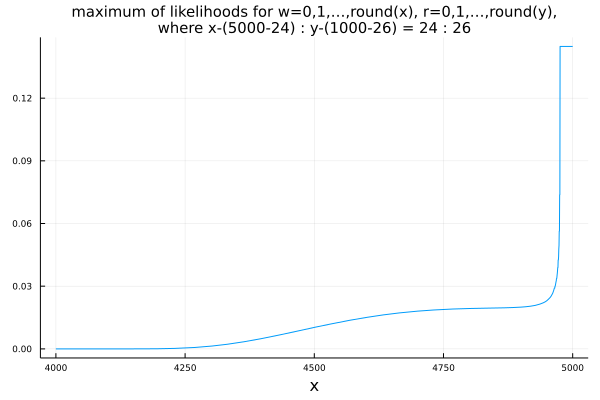

In [14]:
plot(g, 4000, 5000; label="", xguide="x")
title!("maximum of likelihoods for w=0,1,…,round(x), r=0,1,…,round(y),\nwhere x-(5000-24) : y-(1000-26) = 24 : 26")

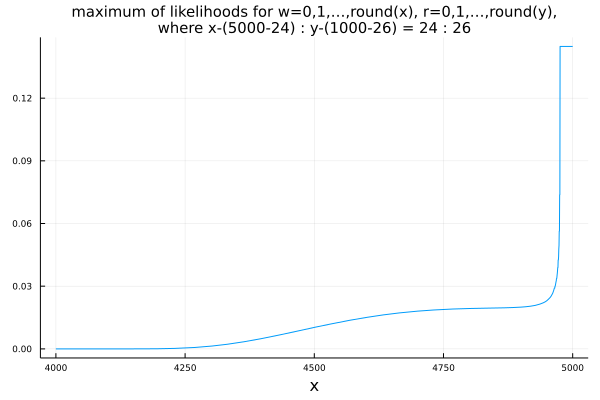

In [15]:
plot(g, 4000, 5000; label="", xguide="x")
title!("maximum of likelihoods for w=0,1,…,round(x), r=0,1,…,round(y),\nwhere x-(5000-24) : y-(1000-26) = 24 : 26")

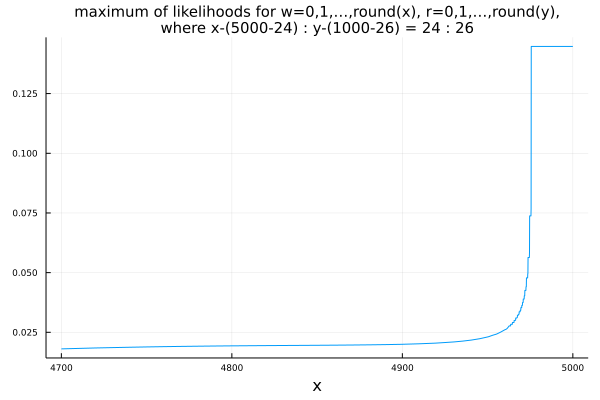

In [16]:
plot(g, 4700, 5000; label="", xguide="x")
title!("maximum of likelihoods for w=0,1,…,round(x), r=0,1,…,round(y),\nwhere x-(5000-24) : y-(1000-26) = 24 : 26")

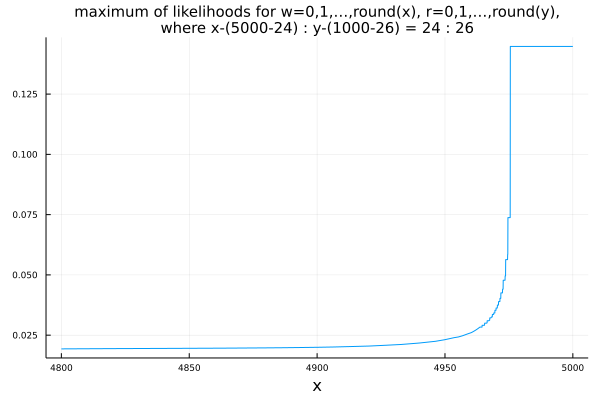

In [17]:
plot(g, 4800, 5000; label="", xguide="x")
title!("maximum of likelihoods for w=0,1,…,round(x), r=0,1,…,round(y),\nwhere x-(5000-24) : y-(1000-26) = 24 : 26")

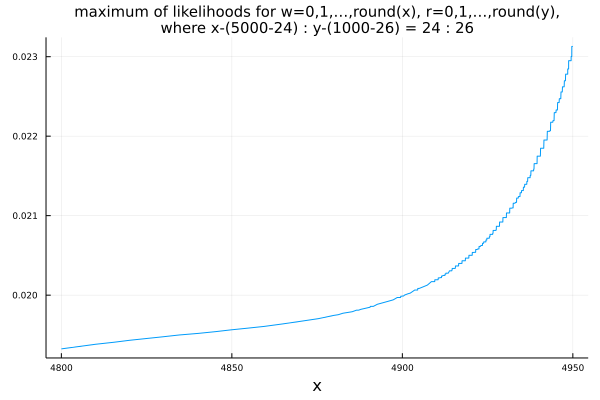

In [18]:
plot(g, 4800, 5000-50; label="", xguide="x")
title!("maximum of likelihoods for w=0,1,…,round(x), r=0,1,…,round(y),\nwhere x-(5000-24) : y-(1000-26) = 24 : 26")

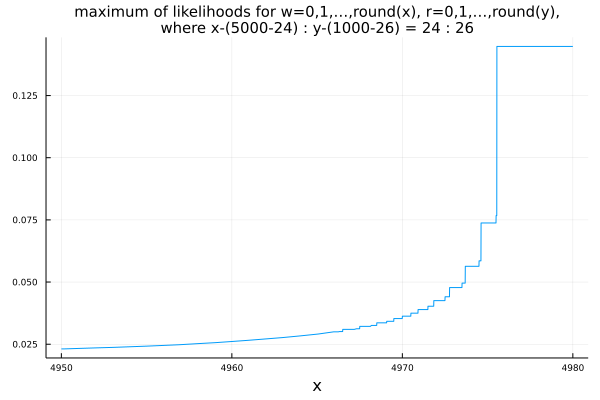

In [19]:
plot(g, 4950, 5000-20; label="", xguide="x")
title!("maximum of likelihoods for w=0,1,…,round(x), r=0,1,…,round(y),\nwhere x-(5000-24) : y-(1000-26) = 24 : 26")

In [20]:
function _pvalue(w, r; a=43, b=7, c=24, d=26, W=5000, R=1000)
    a+b ≤ w+r || return 0.0
    c+d ≤ W+R-(w+r) || return 0.0
    hgA = Hypergeometric(w, r, a+b)
    hgB = Hypergeometric(W-w, R-r, c+d)
    pvalA = min(2cdf(hgA, a), 2ccdf(hgA, a-1))
    pvalB = min(2cdf(hgB, c), 2ccdf(hgB, c-1))
    pvalA * pvalB
end

@memoize function calculate_pvalues(; a=43, b=7, c=24, d=26, W=5000, R=1000)
    pval = Matrix{Float64}(undef, W+1, R+1)
    Ws, Rs = 0:W, 0:R 
    Threads.@threads for j in eachindex(Rs)
        for i in eachindex(Ws)
            pval[i, j] = _pvalue(Ws[i], Rs[j]; a, b, c, d, W, R)
        end
    end
    (; pval, Ws, Rs)
end

function plot_pvalues(f = identity;
        a=43, b=7, c=24, d=26, W=5000, R=1000,
        ws=0:W, rs=0:R, color=:CMRmap, colorbar=true, clims=nothing,
        plot_line=false, plot_contourf=false, 
        title="", kwargs...)
    (; pval, Ws, Rs) = calculate_pvalues(; a, b, c, d, W, R)
    xidx, yidx = 1 .+ ws, 1 .+ rs
    @views if isnothing(clims)
        pvalmin, pvalmax = extrema(f, pval[xidx, yidx])
        clims = (pvalmin - 0.05(pvalmax - pvalmin), pvalmax)
    end
    if plot_contourf
        contourf(Ws[xidx], Rs[yidx], f.(pval[xidx, yidx])'; color, colorbar, clims, kwargs...)
    else
        heatmap(Ws[xidx], Rs[yidx], f.(pval[xidx, yidx])'; color, colorbar, clims, kwargs...)
    end
    plot_line && plot!(x -> (d/c)*(x - W) + R; label="", c=:cyan)
    plot!(xlim=extrema(Ws[xidx]), ylim=extrema(Rs[yidx]))
    plot!(xguide="w", yguide="r")
    title!(title)
end

plot_pvalues (generic function with 2 methods)

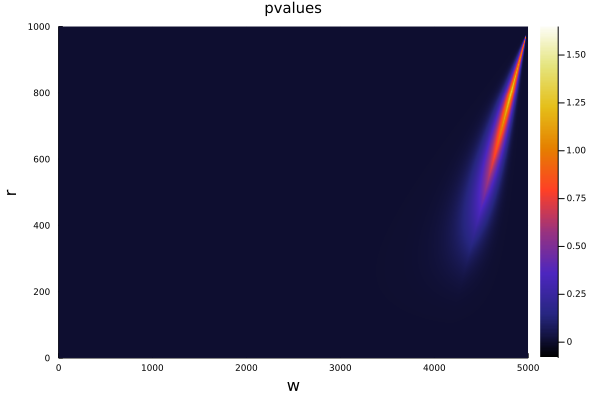

In [21]:
plot_pvalues(; title="pvalues")

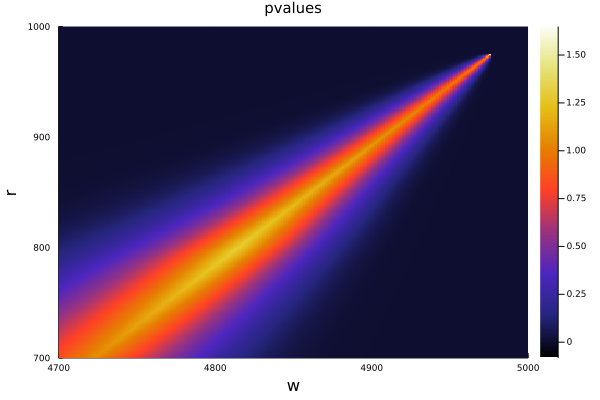

In [22]:
plot_pvalues(ws=4700:5000, rs=700:1000, title="pvalues")

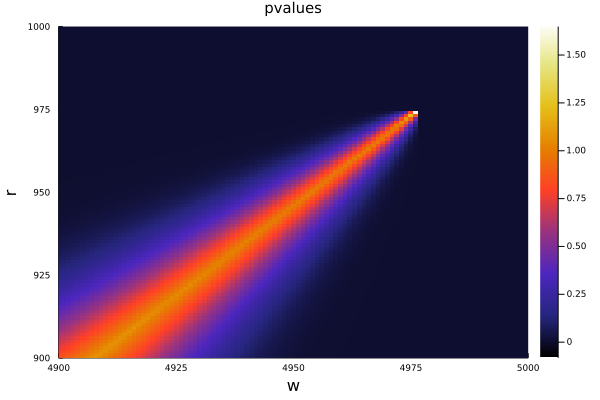

In [23]:
plot_pvalues(ws=4900:5000, rs=900:1000, title="pvalues")

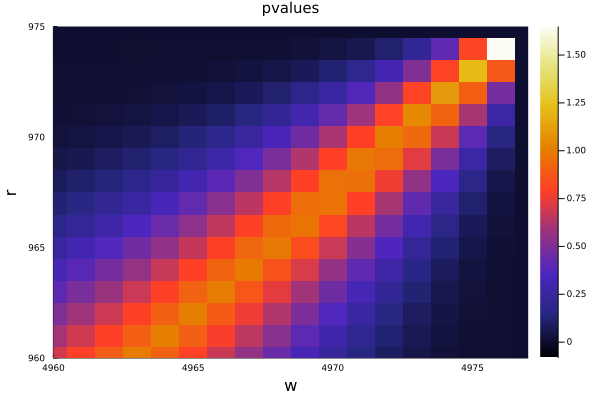

In [24]:
plot_pvalues(ws=4960:4977, rs=960:975, title="pvalues")

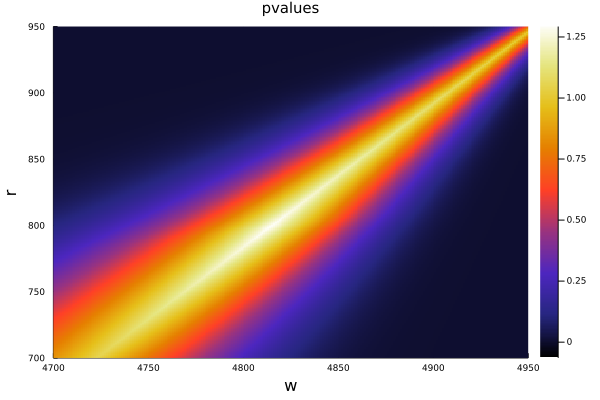

In [25]:
plot_pvalues(ws=4700:4950, rs=700:950, title="pvalues")

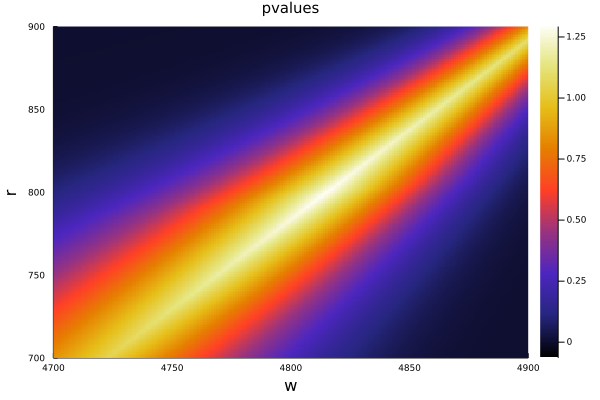

In [26]:
plot_pvalues(ws=4700:4900, rs=700:900, title="pvalues")

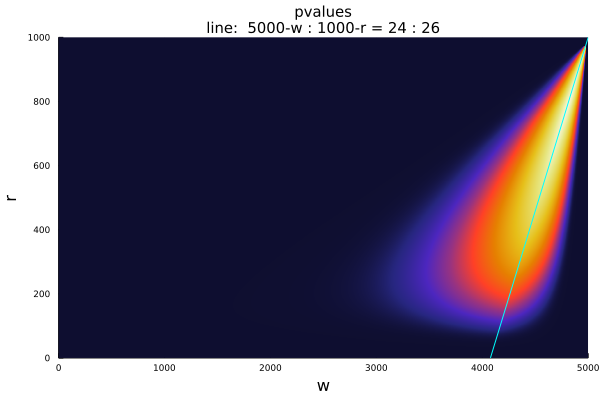

In [27]:
plot_pvalues(p -> log(p + 1e-4); colorbar=false,
    plot_line=true, title="pvalues\nline:  5000-w : 1000-r = 24 : 26")

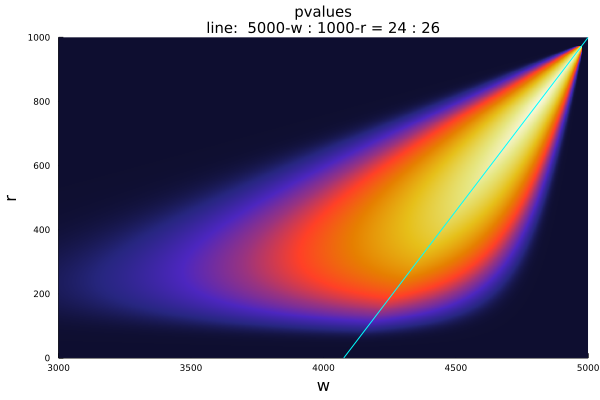

In [28]:
plot_pvalues(p -> log(p + 1e-4); ws=3000:5000, colorbar=false,
    plot_line=true, title="pvalues\nline:  5000-w : 1000-r = 24 : 26")

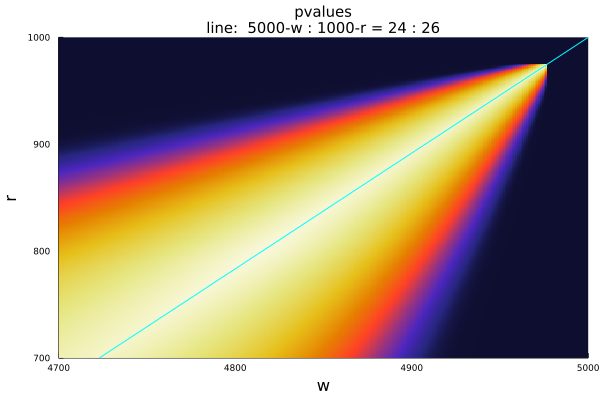

In [29]:
plot_pvalues(p -> log(p + 1e-4); ws=4700:5000, rs=700:1000, colorbar=false,
    plot_line=true, title="pvalues\nline:  5000-w : 1000-r = 24 : 26")

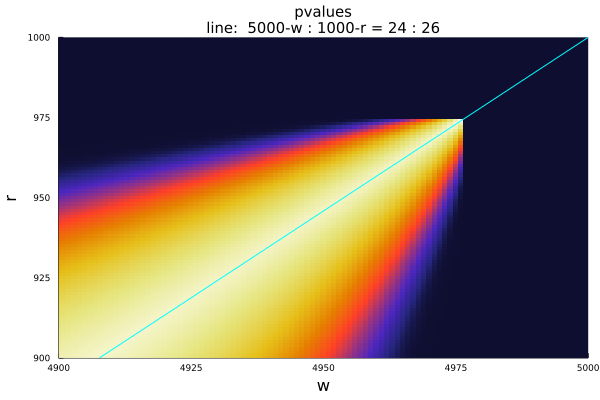

In [30]:
plot_pvalues(p -> log(p + 1e-4); ws=4900:5000, rs=900:1000, colorbar=false,
    plot_line=true, title="pvalues\nline:  5000-w : 1000-r = 24 : 26")

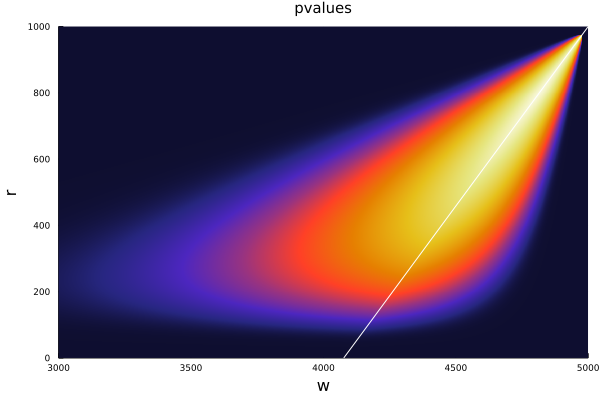

In [31]:
f(x) = (26/24)*(x - (5000-24)) + (1000-26)
plot_pvalues(p -> log(p + 1e-4); ws=3000:5000, colorbar=false, title="pvalues")
plot!(x -> f(x); label="", c=:white)

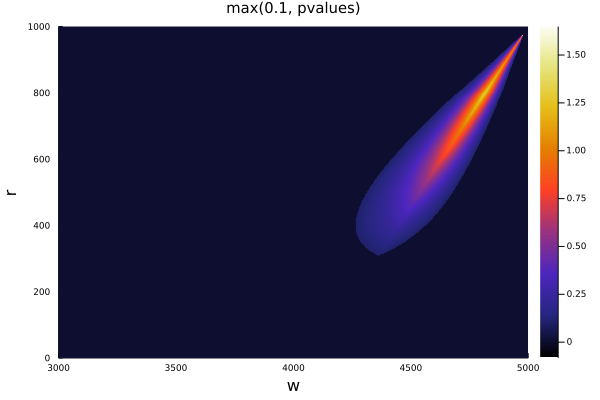

In [32]:
α = 0.1
plot_pvalues(p -> p ≥ α ? p : 0.0; ws=3000:5000, title="max($α, pvalues)")

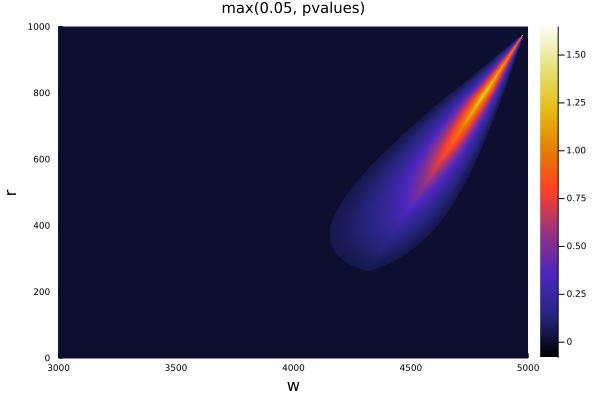

In [33]:
α = 0.05
plot_pvalues(p -> p ≥ α ? p : 0.0; ws=3000:5000, title="max($α, pvalues)")

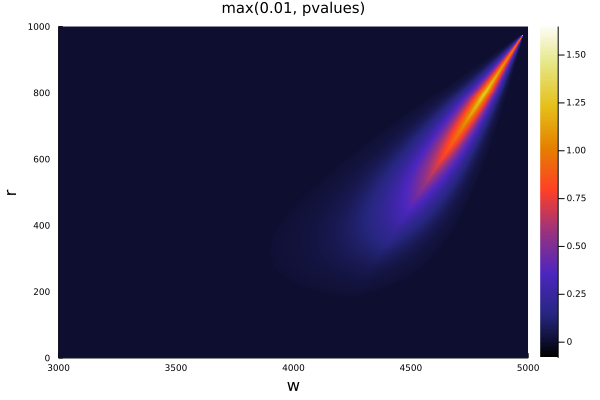

In [34]:
α = 0.01
plot_pvalues(p -> p ≥ α ? p : 0.0; ws=3000:5000, title="max($α, pvalues)")

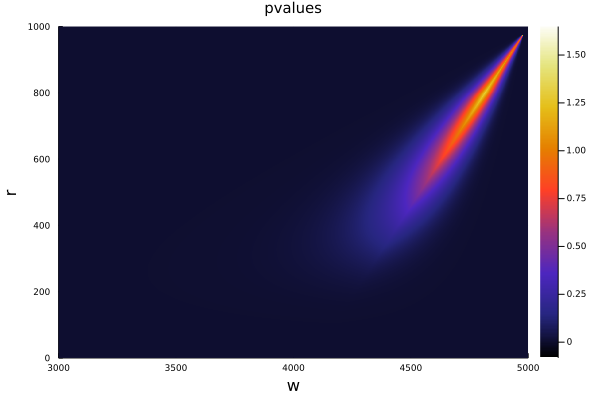

In [35]:
plot_pvalues(ws=3000:5000, title="pvalues")

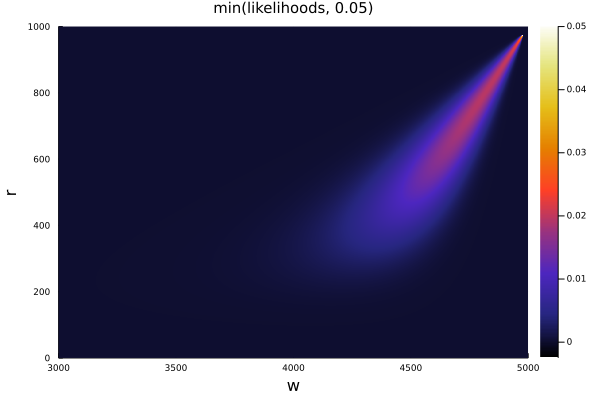

In [36]:
plot_likelihoods(p -> clamp(p, 0.0, 0.05); ws=3000:5000, title="min(likelihoods, 0.05)")

In [37]:
(; pval, Ws, Rs) = calculate_pvalues()
h(x) = @views f(x) ≥ 0 ? maximum(pval[1 .+ (0:round(Int, x)), 1 .+ (0:round(Int, f(x)))]) : 0.0

h (generic function with 1 method)

In [38]:
h(5000-24)

1.6488154867969746

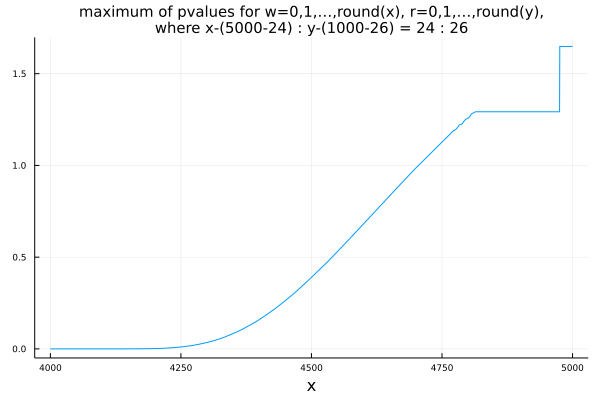

In [39]:
plot(h, 4000, 5000; label="", xguide="x")
title!("maximum of pvalues for w=0,1,…,round(x), r=0,1,…,round(y),\nwhere x-(5000-24) : y-(1000-26) = 24 : 26")

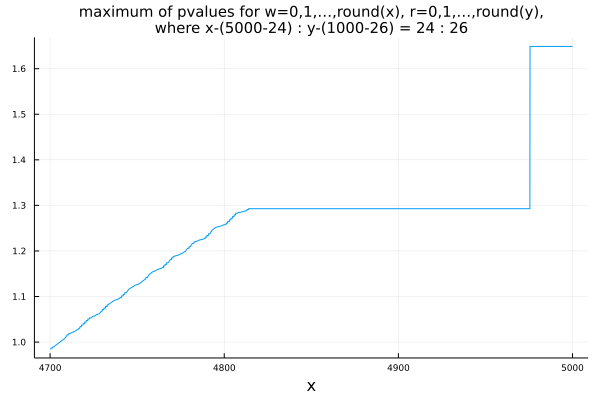

In [40]:
plot(h, 4700, 5000; label="", xguide="x")
title!("maximum of pvalues for w=0,1,…,round(x), r=0,1,…,round(y),\nwhere x-(5000-24) : y-(1000-26) = 24 : 26")

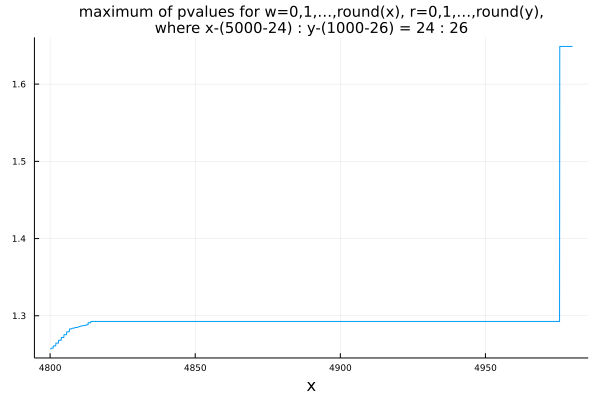

In [41]:
plot(h, 4800, 5000-20; label="", xguide="x")
title!("maximum of pvalues for w=0,1,…,round(x), r=0,1,…,round(y),\nwhere x-(5000-24) : y-(1000-26) = 24 : 26")

In [42]:
h.(4814:4816)

3-element Vector{Float64}:
 1.2909547209119625
 1.292679950879147
 1.292679950879147

In [43]:
h.(5000-26:5000-24)

3-element Vector{Float64}:
 1.292679950879147
 1.292679950879147
 1.6488154867969746

In [44]:
all(h.(4815:5000-25) .== h(4815))

true